## Model description

In [44]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

import covid_19.covid_func as cf

Data source for Chicago:

https://www.chicago.gov/city/en/sites/covid-19/home/latest-data.html

Pickle file is created in `create_data_pickles.ipynb` notebook.

Note that these numbers for Chicago do get updated even more than a week after the fact. It appears that they are trying to record accurate dates for these deaths, rather than simply keeping track of when they were reported/announced. This is not always the case for other agencies.

In [45]:
death_df = pd.read_pickle('../data/chi_deaths.pickle')

In [46]:
death_df.iloc[-10:]

,deaths
2020-04-06,18
2020-04-07,22
2020-04-08,33
2020-04-09,20
2020-04-10,26
2020-04-11,27
2020-04-12,29
2020-04-13,24
2020-04-14,20
2020-04-15,17


In [47]:
# Drop the last 7 days, to reduce the effects of incomplete data
death_df = death_df.iloc[:-7]

In [48]:
num_days = len(death_df)

In [49]:
death_list = list(death_df['deaths'])

#### Do a convolution

Incubation period from https://www.mdpi.com/2077-0383/9/2/538:

Lognormal distribution with mean 5.6 days, SD 2.8 days.

In [50]:
# Use lognorm_pdf function defined in covid_func.py
mean_i = 5.6
sd_i = 2.8

incubation_pdf = cf.lognorm_pdf(mean_i, sd_i)

In [51]:
incubation_array = np.array([incubation_pdf(x) for x in range(num_days)])

Onset-to-death delay from https://www.sciencedirect.com/science/article/pii/S1473309920302437

Gamma function with mean 17.8 days, coefficient of variation 0.45.

In [52]:
# Use gamma_pdf function defined in covid_func.py
mean_d = 17.8
cov_d = 0.45
sd_d = mean_d * cov_d

delay_pdf = cf.gamma_pdf(mean_d, sd_d)

In [53]:
delay_array = np.array([delay_pdf(x) for x in range(num_days)])

Given an array of infections, create a transfer matrix that turns it in to an array of cases with symptoms. The function to do this is defined in `covid_func.py`.

This is not exactly correct, as it ignores asymptotic cases, but I will multiply the whole array by the infection fatality rate (IFR) so the final answer will be modeled correctly.

In [54]:
incubation_mat = cf.create_delay_matrix(incubation_array, num_days)

It looks like this.

In [55]:
incubation_mat[:5,:5]

array([[0.        , 0.00251436, 0.06388876, 0.15624861, 0.18851108],
       [0.        , 0.        , 0.00251436, 0.06388876, 0.15624861],
       [0.        , 0.        , 0.        , 0.00251436, 0.06388876],
       [0.        , 0.        , 0.        , 0.        , 0.00251436],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Similarly

In [56]:
delay_mat = cf.create_delay_matrix(delay_array, num_days)

Multiply these 2 matrices to get the transfer matrix to go from the array of infections to the array of deaths (up to the factor of IFR).

In [57]:
transfer_mat = np.matmul(incubation_mat, delay_mat)

#### Generation interval

Following https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-13-europe-npi-impact/, take the generation interval to be drawn from a Gamma distribution, with mean 6.5 days, SD of 0.6 * 6.5 days. (In the paper, this is described as the serial interval, but the quantity in interest is the generation interval.)

There are estimates of mean serial interval and generation interval in the 4-day range. Using a shorter interval leads to a lower estimated R, given the same growth.

In [58]:
mean_g = 6.5
sd_g = 0.6 * 6.5

generation_pdf = cf.gamma_pdf(mean_g, sd_g)

In [59]:
generation_array = np.array([generation_pdf(x)
                             for x in range(num_days)])

At first, you have an array of infections, `[N_0, 0, 0, ...]`. You then multiply by R0 * generation_array to get the new infections generated from that first patient.

Add these patients to the infections array, then you multiply the 2nd element by a shifted version of generation_array, to get the new infections from those people.

This requires a successive multiplication by matrices. `create_infection_tensor` is a 3 dimensional array whose n-th element is the n-th matrix required in this process.

In [60]:
infection_tensor = cf.create_infection_tensor(generation_array, num_days)

#### Define the model

In [61]:
with pm.Model() as model:
    # There is some initial number of cases
    # The prior is an exponential distribution with mean 1.
    N_0 = pm.Exponential('initial', lam=1.)

    # There is a constant reproduction number.
    # The prior is distributed normally around 3.
    R_0 = pm.Normal('R_0', mu=3., sd=2.)
    
    # The infection array is generated iteratively,
    # using the series of matrices generated above,
    # and R0 as a multiplicative factor at each stage.
    N_array = N_0 * np.array([1.] + [0.] * (num_days - 1))
    for tensor in infection_tensor[:-1]:
        N_array += R_0 * pm.math.matrix_dot(N_array,
                                            tensor)
    # IFR is calculated using 
    # https://www.sciencedirect.com/science/article/pii/S1473309920302437
    # and the population by age in the US        
    IFR = 0.0095
    
    # Model proceeds as new infections -> expected new patients
    #                                  -> expected new deaths,
    # using the transfer matrices and the IFR
    exp_deaths = IFR * pm.math.matrix_dot(N_array, transfer_mat)

In [62]:
with model:
    # Given expected numbers of deaths,
    # fit to the data assuming this is a Poisson process for each day.
    D = pm.Poisson('deaths', mu=exp_deaths, observed=death_list)

In [63]:
with model:
    # Monte Carlo sampling to find the posterior distribution numerically
    step = pm.NUTS()
    trace = pm.sample(10000, tune=10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R_0, initial]
Sampling 2 chains, 9 divergences: 100%|██████████| 40000/40000 [05:30<00:00, 121.21draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5911712820095116, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.509655570053211, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


I sometimes get divergences. This is not a good sign, and I welcome any ideas for avoiding them.

/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


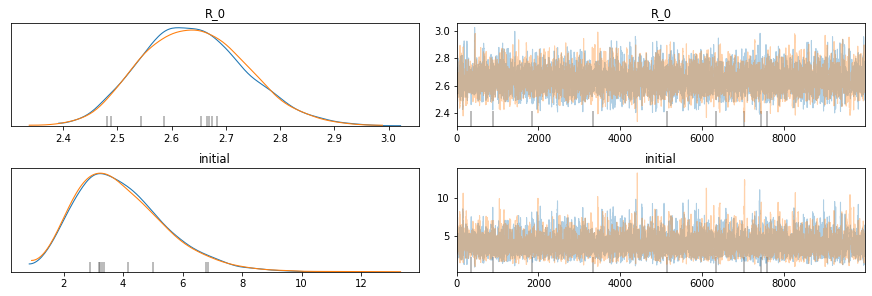

In [64]:
pm.traceplot(trace)
plt.show()

Create arrays for all simulation results.

In [65]:
initial_array = np.array(trace['initial'])
R_0_array = np.array(trace['R_0'])

Calculate the predicted number of infections for all dates, for each simulation.

In [66]:
# This is the set of predictions for all simulations for each day
N_matrix = cf.batch_predict_N_generation(initial_array=initial_array,
                                         R_0_array=R_0_array,
                                         num_days=num_days)

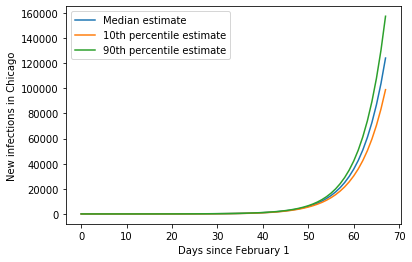

In [67]:
x = np.arange(num_days)
y_median = cf.percentile_prediction(N_matrix, 50)
y_10 = cf.percentile_prediction(N_matrix, 10)
y_90 = cf.percentile_prediction(N_matrix, 90)
plt.plot(x, y_median, label='Median estimate')
plt.plot(x, y_10, label='10th percentile estimate')
plt.plot(x, y_90, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel('New infections in Chicago')
plt.legend()
plt.show()

This is still an unrealistic model, because it assumes that the growth keeps going forever. Again, we will see where things go wrong below.

Calculate the expected number of deaths, and compare the predictions with actual numbers.

In [68]:
deaths_matrix = cf.batch_predict_deaths_from_infections(N_matrix,
                                                        incubation_pdf,
                                                        delay_pdf)

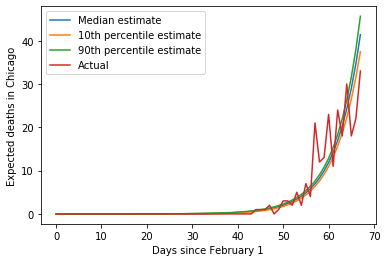

In [69]:
x = np.arange(num_days)
deaths_median = cf.percentile_prediction(deaths_matrix, 50)
deaths_10 = cf.percentile_prediction(deaths_matrix, 10)
deaths_90 = cf.percentile_prediction(deaths_matrix, 90)
plt.plot(x, deaths_median, label='Median estimate')
plt.plot(x, deaths_10, label='10th percentile estimate')
plt.plot(x, deaths_90, label='90th percentile estimate')
plt.plot(x, death_list, label='Actual')
plt.xlabel('Days since February 1')
plt.ylabel('Expected deaths in Chicago')
plt.legend()
plt.show()

This is not a terrible fit, but the last segment shows signs that the growth rate is now sub-exponential, making this a bad model.